# Mellrák bináris klasszifikáció
(https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import sys, os, shutil, random
import seaborn as sns
import sklearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
from PIL import Image
import cv2

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [4]:
# Setting up Kaggle API
# !pip install kaggle
# !mkdir ~/.kaggle
!cp '~/Downloads/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
# Downloading dataset
!kaggle datasets download -d paultimothymooney/breast-histopathology-images


  0%|          | 0.00/3.10G [00:00<?, ?B/s]
  0%|          | 1.00M/3.10G [00:00<11:37, 4.77MB/s]
  0%|          | 2.00M/3.10G [00:00<09:17, 5.97MB/s]
  0%|          | 3.00M/3.10G [00:00<08:33, 6.47MB/s]
  0%|          | 4.00M/3.10G [00:00<08:08, 6.81MB/s]
  0%|          | 5.00M/3.10G [00:00<07:57, 6.96MB/s]
  0%|          | 6.00M/3.10G [00:00<07:50, 7.05MB/s]
  0%|          | 7.00M/3.10G [00:01<07:45, 7.12MB/s]
  0%|          | 8.00M/3.10G [00:01<07:43, 7.16MB/s]
  0%|          | 9.00M/3.10G [00:01<07:40, 7.20MB/s]
  0%|          | 10.0M/3.10G [00:01<07:37, 7.25MB/s]
  0%|          | 11.0M/3.10G [00:01<07:35, 7.28MB/s]
  0%|          | 12.0M/3.10G [00:01<07:34, 7.30MB/s]
  0%|          | 13.0M/3.10G [00:01<07:34, 7.29MB/s]
  0%|          | 14.0M/3.10G [00:02<07:34, 7.29MB/s]
  0%|          | 15.0M/3.10G [00:02<07:35, 7.27MB/s]
  1%|          | 16.0M/3.10G [00:02<07:33, 7.31MB/s]
  1%|          | 17.0M/3.10G [00:02<07:32, 7.31MB/s]
  1%|          | 18.0M/3.10G [00:02<07:31, 7.32MB/s]
 

In [ ]:
# Unzip it
!mkdir data
!unzip breast-histopathology-images -d data/

'unzip' is not recognized as an internal or external command,
operable program or batch file.


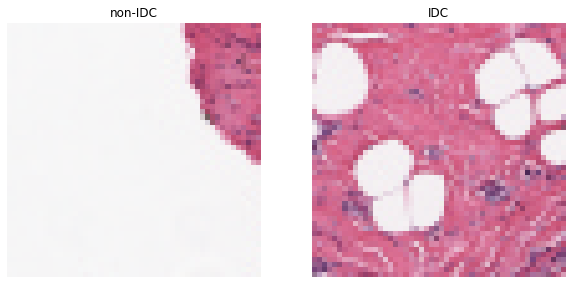

In [2]:
# Check some samples
plt.figure(figsize=(10,5))

# Negative image (Non cancerous)
ax = plt.subplot(1, 2, 1)
plt.imshow(keras.utils.load_img('data/8863/0/8863_idx5_x51_y1251_class0.png'))
plt.title('non-IDC')
plt.axis('off')

# Positive images (Cancerous)
ax = plt.subplot(1, 2, 2)
plt.imshow(keras.utils.load_img('data/8863/1/8863_idx5_x1001_y801_class1.png'))
plt.title('IDC')
plt.axis('off')
plt.show()


In [3]:
# Checking how imbalanced the classes are
pos_train = len(glob('sorted/train/1/*'))
neg_train = len(glob('sorted/train/0/*'))
pos_test = len(glob('sorted/test/1/*'))
neg_test = len(glob('sorted/test/0/*'))
print(f"train: 0 -> {neg_train / (pos_train + neg_train)}, 1 -> {pos_train / (pos_train + neg_train)}")
print(f"test: 0 -> {neg_test / (pos_test + neg_test)}, 1 -> {pos_test / (pos_test + neg_test)}")

train: 0 -> 0.7166449878598682, 1 -> 0.2833550121401318
test: 0 -> 0.7134843443392203, 1 -> 0.2865156556607798


In [3]:
# Grabbing all the image locations from the data folder
imagePatches = glob('data/**/*.png', recursive=True)

# Two arrays holding images by class type
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

# Filling the 2 class arrays
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [6]:
print(class0[0:10])

['data\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'data\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'data\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'data\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'data\\10253\\0\\10253_idx5_x1001_y1201_class0.png', 'data\\10253\\0\\10253_idx5_x1001_y1251_class0.png', 'data\\10253\\0\\10253_idx5_x1001_y1301_class0.png', 'data\\10253\\0\\10253_idx5_x1001_y1351_class0.png', 'data\\10253\\0\\10253_idx5_x1001_y1501_class0.png', 'data\\10253\\0\\10253_idx5_x1001_y1551_class0.png']


In [75]:
# Random oversampling with positive images (Will increase overfit)
for filename in random.sample(class1, int(len(class1) / 16)):
    class1.append(filename)

In [7]:
# Select some negative and positive image paths (amount of positive classes)
# This will automatically produce random undersampling on the negative images
sampled_class0 = random.sample(class0, len(class1))
sampled_class1 = random.sample(class1, len(class1))

print(len(sampled_class0))
print(len(sampled_class1))

78786
78786


In [10]:
IMAGE_SIZE = [50, 50]

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (IMAGE_SIZE[0],IMAGE_SIZE[1]), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [11]:
# Get the selected images to 2 a positive and negative array
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [ ]:
print(class0_array[0])

NameError: name 'class0_array' is not defined

In [7]:
# Combine the 2 arrays into one dataset
combined_data = np.concatenate((class0_array, class1_array))
random.seed(69)
random.shuffle(combined_data)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [8]:
# Data splitting
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

# Splitting the data into 0.8/0.2 train/test ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Converting to numpy arrays just in case
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Shapes of the arrays
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_test[0:10])

(252115, 50, 50, 3) (63029, 50, 50, 3) (252115,) (63029,)
[0 0 0 0 0 0 0 0 0 0]


In [10]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

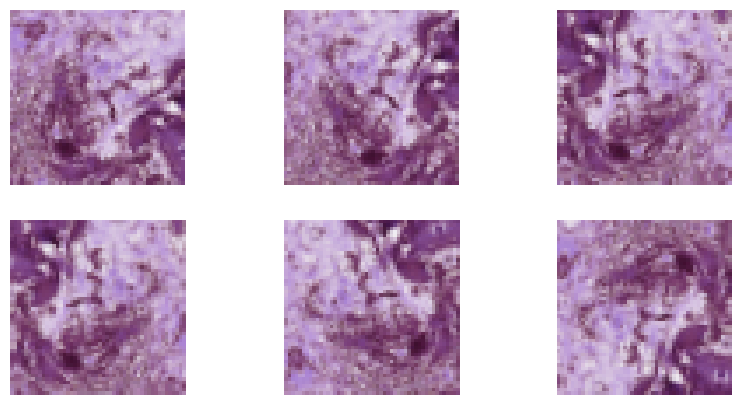

In [11]:
# Some augmented images
plt.figure(figsize=(10,5))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    augmented_img = data_augmentation(tf.expand_dims(X_test[0], 0))
    plt.imshow(augmented_img[0] / 255)
    plt.axis('off')

In [48]:
# Calculate the bias bc data is imbalanced
initial_bias = np.log([pos_train/neg_train])
initial_bias

# Making class weight to heavily favor cancerous sample bc imbalance
non_idc_weight = (1 / len(class0)) * ((len(class0) + len(class1)) / 2.0)
idc_weight = (1 / len(class1)) * ((len(class0) + len(class1)) / 2.0)
class_weight = {0: non_idc_weight, 1: idc_weight}

print(f"Weight for non-IDC: {non_idc_weight}")
print(f"Weight for IDC: {idc_weight}")
print(f"Class weight: {class_weight}")

Weight for non-IDC: 0.8964302247179703
Weight for IDC: 1.1306280006219398
Class weight: {0: 0.8964302247179703, 1: 1.1306280006219398}


In [12]:
# Building the classification model
i = layers.Input(shape=IMAGE_SIZE + [3])
# Preprocessing
x = data_augmentation(i)
x = layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1])(x)
x = layers.Rescaling(1./255)(x)
# Processing
x = layers.Conv2D(16, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)

# x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.AveragePooling2D()(x)

# x = layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.AveragePooling2D()(x)
# Afterwork
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(2, activation='sigmoid')(x) # bias_initializer=initializers.Constant(initial_bias)

model = keras.Model(i, x)

model.compile(loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    # run_eagerly=True,
    metrics=
    [
        'accuracy'
    ])

In [11]:
# Load weights for continuing training
model.load_weights('./weights/custom_cnn_breast_cancer_2022-10-21')

In [58]:
# Function to enable fitting the model with multiple smaller train dataset bc my VRAM is too small
def TrainModel(X_train: np.array, y_train: np.array):
    # Fit
    r = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_test, y_test),
        epochs=3,
        # class_weight=class_weight,
        callbacks=[         
            tf.keras.callbacks.EarlyStopping(  
                monitor='val_loss',
                patience=5,
                restore_best_weights=True #it literally means wat u think (simpleeeeee)
            )
        ]
    )

In [ ]:
# Running the fitting to smaller datasets
div_amount = 32
X_div_len = int(len(X_train) / div_amount)
y_div_len = int(len(y_train) / div_amount)
for i in range(1, div_amount):
    TrainModel(X_train[(i - 1) * X_div_len : i * X_div_len], y_train[(i - 1) * y_div_len : i * y_div_len])

In [17]:
r = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_test, y_test),
        epochs=12,
        # class_weight=class_weight,
        callbacks=[         
            tf.keras.callbacks.EarlyStopping(  
                monitor='val_loss',
                patience=5,
                restore_best_weights=True #it literally means wat u think (simpleeeeee)
            )
        ]
    )

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

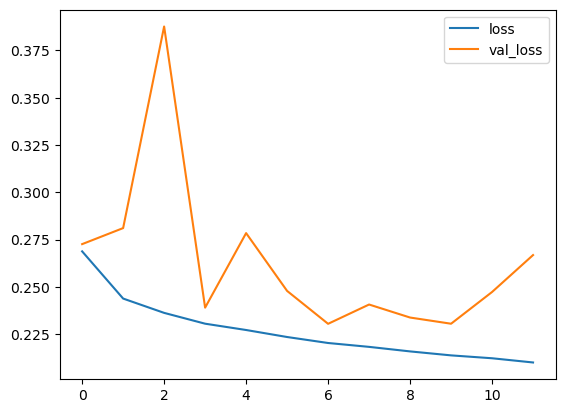

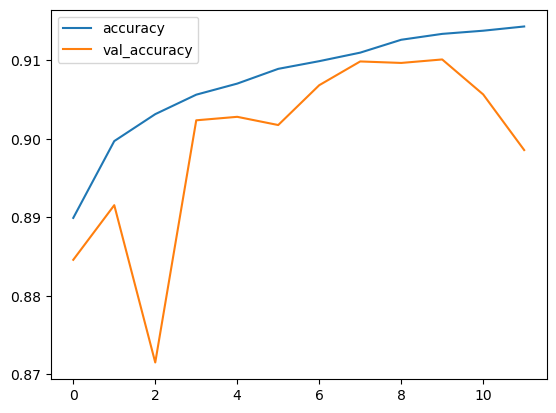

In [14]:
# Plotting the model loss to see the results
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Plotting the model accuracy to see the results
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# # Plotting the model recall to see the results
# plt.plot(r.history['recall'], label='recall')
# plt.plot(r.history['val_recall'], label='val_recall')
# plt.legend()
# plt.show()

# # Plotting the model precision to see the results
# plt.plot(r.history['precision'], label='precision')
# plt.plot(r.history['val_precision'], label='val_precision')
# plt.legend()
# plt.show()

# # Plotting the model AUC to see the results
# plt.plot(r.history['auc'], label='auc')
# plt.plot(r.history['val_auc'], label='val_auc')
# plt.legend()
# plt.show()

1970/1970 [==============================] - 5s 3ms/step


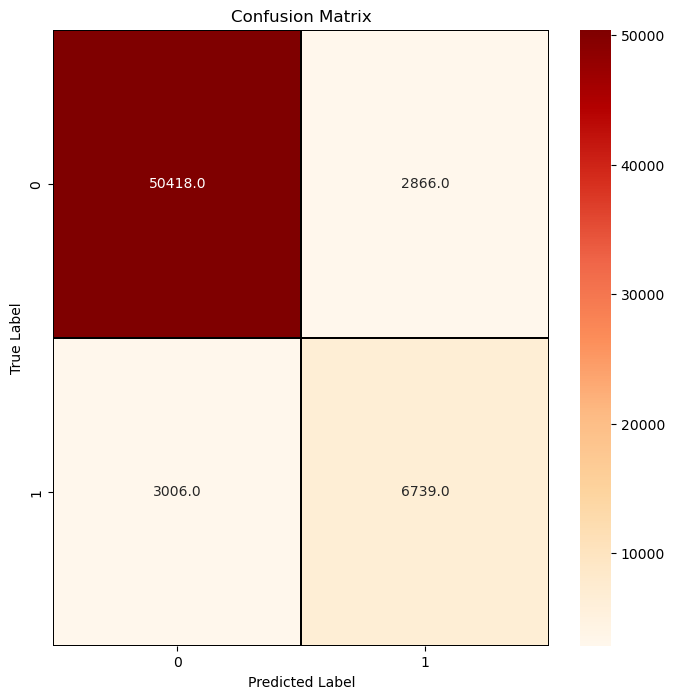

In [15]:
# Prediction v2
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = sklearn.metrics.confusion_matrix(y_test, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# Calculate AUC
m = tf.keras.metrics.AUC(num_thresholds=200)
m.update_state(y_true=y_test, y_pred=Y_pred_classes)
m.result().numpy()

0.8188734

In [29]:
print(Y_pred[0:10])
print(test_preds[0:10])
print(Y_pred_classes[0:10])

[[0.50427455 0.49349466]
 [0.5037589  0.16607185]
 [0.89719373 0.13011152]
 [0.6525506  0.13422687]
 [0.9430096  0.00162952]
 [0.42738044 0.007086  ]
 [0.22554882 0.01869062]
 [0.6950066  0.01757893]
 [0.7806859  0.00639587]
 [0.48676986 0.1616401 ]]
[1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


In [30]:
# Help for imbalanced datasets https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
def PlotConfusionMatrix():
    # Plotting confusion matrix
    cf_matrix = sklearn.metrics.confusion_matrix(y_test, Y_pred_classes, normalize='all')
    plt.figure(figsize=(6,6))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    # Adding title names
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    # Adding label names to each category
    ax.xaxis.set_ticklabels(["Negative", "Positive"])
    ax.yaxis.set_ticklabels(["Negative", "Positive"])

    plt.show()

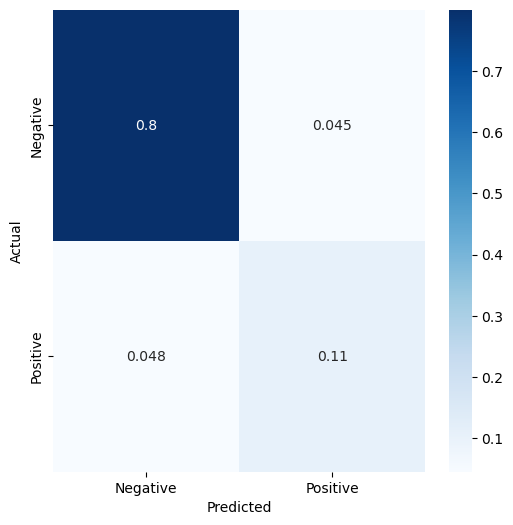

In [31]:
# Plot confusion matrix with the DEFAULT threshold value
PlotConfusionMatrix()

In [32]:
# Defining the ROC (TP vs FP curve) and AUPRC (Precision-Recall curve) functions
def PlotROC(labels, preds):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, preds)
    # Calculate the g-mean for each threshold
    gmeans = np.sqrt(tp * (1-fp))
    # Locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print(f"Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}")
    # Plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fp, tp, marker='.', label='CNN')
    plt.scatter(fp[ix], tp[ix], marker='o', color='green', label='Best')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return thresholds[ix]
    
def PlotPRC(labels, preds):
    # Calculate pr-curve
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, preds)
    # Calculating the best f-score
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print(f"Best threshold: {thresholds[ix]}, Best F-score: {fscore[ix]}")
    # Plot the ROC curve
    no_skill = len(labels[labels==1]) / len(labels)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='CNN')
    plt.scatter(recall[ix], precision[ix], marker='o', color='green', label='Best')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return thresholds[ix]


In [33]:
# Get only the positive tests probs
Y_pred_pos_probs = list()
for prob in Y_pred:
    Y_pred_pos_probs.append(prob[1])
len(Y_pred_pos_probs)

63029

Best Threshold=0.3739966154098511, G-Mean=0.9378154278621895


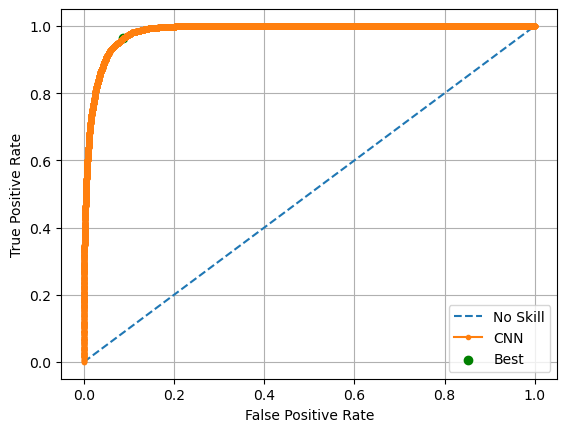

Best threshold: 0.4746289849281311, Best F-score: 0.8348956758391292


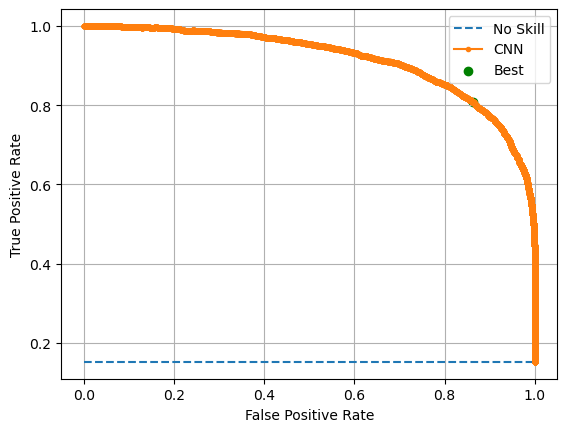

In [34]:
# Plotting optimal threshold of ROC Curve
best_roc_threshold = PlotROC(Y_pred_classes, Y_pred_pos_probs)
# Plotting optimmal threshold of PRC. Looks pretty awful ngl (PRC only cares about the minority class)
best_prc_threshold = PlotPRC(Y_pred_classes, Y_pred_pos_probs)

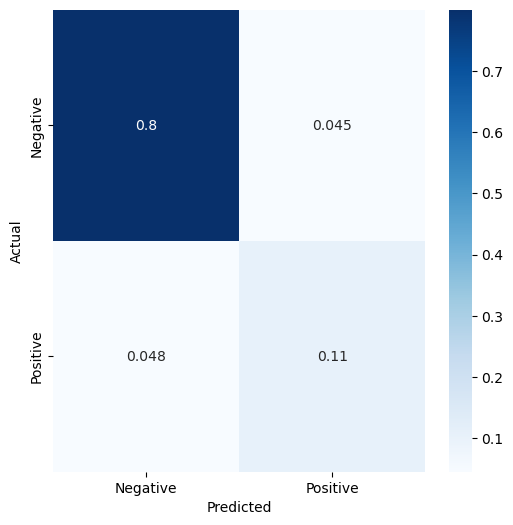

In [35]:
# Converting the probabilites to concrete ROC predicitions
test_preds = tf.where(Y_pred > best_roc_threshold, 1, 0)
# test_preds = list()
# for i in Y_pred:
#     if i[1] > best_roc_threshold:
#         test_preds.append(1)
#     else:
#         test_preds.append(0)

# test_preds = np.array(test_preds)
PlotConfusionMatrix()

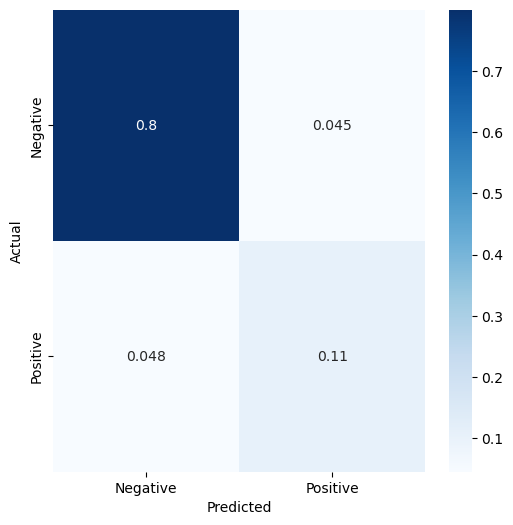

In [36]:
# Converting the probabilites to concrete PRC predicitions
test_preds = tf.where(Y_pred > best_prc_threshold, 1, 0)
# test_preds = list()
# for i in Y_pred:
#     if i[1] > best_prc_threshold:
#         test_preds.append(1)
#     else:
#         test_preds.append(0)

# test_preds = np.array(test_preds)
PlotConfusionMatrix()

In [37]:
# Save class weights bc we need to configure the dataset bc of imbalance
model.save_weights('./weights/custom_cnn_breast_cancer_2022-11-10-sigmoid')

In [38]:
# Saving model
saved_model = tf.saved_model.save(model, '/tmp/custom_cnn_breast_cancer_2022-11-10-sigmoid')

# Converting model to TF Lite
converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/custom_cnn_breast_cancer_2022-11-10-sigmoid')
tflite_model = converter.convert()

# Save the model.
with open('custom_cnn_breast_cancer_2022-11-10-sigmoid.tflite', 'wb') as f:
  f.write(tflite_model)
